In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable


import random
import bezier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from main import set_path
from Generator import MSTCN_gen
from triplet import TripletDataset2, TripletLoss
from triplet import TripletNet, get_embedding_net
from triplet import TripletLoss, TripletNet, get_embedding_net



def get_actiondict(mapping_file):
    actions_dict = {}
    with open(mapping_file, 'r') as f:
        actions = f.read().split('\n')[:-1]
    for a in actions:
        actions_dict[a.split()[1]] = int(a.split()[0])
        
    return actions_dict


def embeddings3d_plot(embeddings, batch_target, name, step):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(f"Embedding Plot: {name}")
    ax = fig.add_subplot(projection='3d')
    labels = np.array(batch_target.squeeze())
    frames = embeddings.shape[1]
    index = np.arange(0, frames, step)


    for i in index:
        c1 = colors[labels[i]]
        ax.scatter(
            embeddings[0, i],    # x-coordinates.
            embeddings[1, i],    # y-coordinates.
            embeddings[2, i],    # z-coordinates.
            s = 10,
            color=c1

        )
#     plt.savefig(f'./fig/ablation/2/{name}.jpeg')
    plt.show()
    plt.close()
    

Device: cuda:0
Create triplet model for rgb-15-1
=============================================Training Start!===============================================

Epoch 10/100 | 	Learning Rate 0.004900	 | Loss 0.379230
Epoch 20/100 | 	Learning Rate 0.004802	 | Loss 0.716976
Epoch 30/100 | 	Learning Rate 0.004706	 | Loss 2.004178
Epoch 40/100 | 	Learning Rate 0.004612	 | Loss 0.000000
Epoch 50/100 | 	Learning Rate 0.004520	 | Loss 0.000000
Epoch 60/100 | 	Learning Rate 0.004429	 | Loss 0.000000
Epoch 70/100 | 	Learning Rate 0.004341	 | Loss 0.000000
Epoch 80/100 | 	Learning Rate 0.004254	 | Loss 0.000000
Epoch 90/100 | 	Learning Rate 0.004169	 | Loss 5.014934
Epoch 100/100 | 	Learning Rate 0.004085	 | Loss 0.000000
Visualization on rgb-15-1


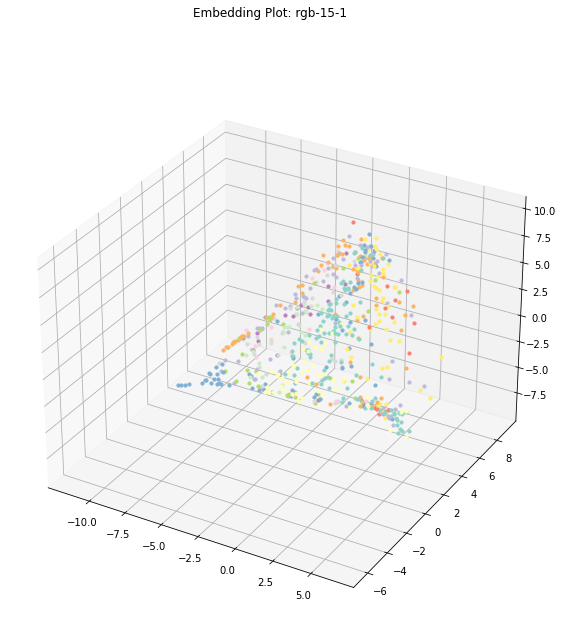

Create triplet model for rgb-14-2
=============================================Training Start!===============================================

Epoch 10/100 | 	Learning Rate 0.004900	 | Loss 0.767166
Epoch 20/100 | 	Learning Rate 0.004802	 | Loss 0.728859
Epoch 30/100 | 	Learning Rate 0.004706	 | Loss 0.000000


KeyboardInterrupt: 

In [6]:
## Set GPU device ##
GPU    = 0
device = torch.device("cuda:{}".format(GPU) if torch.cuda.is_available() else "cpu")
seed   = 1538574472
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
print("Device:", device)


## Set Basic Things ##
dataset      = '50salads'
mapping_file = f'../data/{dataset}/mapping.txt'
actions_dict = get_actiondict(mapping_file)
num_classes  = len(actions_dict)
batch_size   = 1
op           = 'residual'
method       = 'triplet'
step         = 10
margin       = 10.
lr           = 0.005
num_epochs   = 100
colors       = sns.color_palette("Set3", len(actions_dict)) ## 색상 지정


if dataset  == "50salads": sample_rate = 2
else: sample_rate=1
    
    




vid_list_file, features_path, gt_path, _, _, _ = set_path(dataset, 'train', '4', op, method)
batch_gen = MSTCN_gen(num_classes, actions_dict, gt_path, features_path, sample_rate, method)
batch_gen.read_data(vid_list_file)
while batch_gen.has_next():
    batch_input, batch_target, _, name = batch_gen.next_batch(1)
    name = name[0][:-4]
    
    ## Triplet Dataset ##
    triplet_data = {}
    triplet_data[name] = [batch_input.squeeze(), batch_target.squeeze()]
    triplet_dataset    = TripletDataset2(triplet_data, actions_dict)
    triplet_loader     = DataLoader(triplet_dataset, batch_size, shuffle=True)
    
    ## Triplet Network ##
    print(f"Create triplet model for {name}")
    embedding_net   = get_embedding_net()
    triplet_model   = TripletNet(embedding_net, actions_dict).to(device)
    triplet_loss    = TripletLoss(margin)
    optimizer       = optim.Adam(triplet_model.parameters(), lr=lr)
    scheduler       = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                    lr_lambda=lambda epoch: 0.98 ** epoch,
                                    last_epoch=-1) 
    
    loss_list = []
    print('=============================================Training Start!===============================================', end = '\n\n')
    triplet_model.train()
    for epoch in range(num_epochs):

        epoch_loss = 0

        for i, (anchor, positive, negative, anchor_label) in enumerate(triplet_loader):

            data = (Variable(anchor.squeeze(), requires_grad=True).to(device), 
                    Variable(positive.squeeze(), requires_grad=True).to(device), 
                    Variable(negative.squeeze(), requires_grad=True).to(device))

            outputs = triplet_model(*data)
            optimizer.zero_grad()

            loss = triplet_loss(*outputs)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()


        if (epoch + 1) % 10 == 0 :
            scheduler.step()
            print("Epoch {}/{} | \tLearning Rate {:4f}\t | Loss {:4f}".format(epoch+1, num_epochs, scheduler.get_lr()[0], epoch_loss))
            
#     print(f'save the {name} model on ./models/ablation/triplet_{dataset}_{name}')
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': triplet_model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),

#                 }, f'./models/ablation/triplet1_{dataset}_{name}')
        
    print(f"Visualization on {name}")
    batch_input.squeeze_()
    frames      = batch_input.shape[0]
    index       = np.arange(0, frames, step)
    embeddings = triplet_model.get_embedding(batch_input.T.to(device)).T.detach().cpu().numpy()
    embeddings3d_plot(embeddings, batch_target, name, step)